In [1]:
import json
import torch
import gc
import matplotlib.pyplot as plt
import quad

from utils import init_sequential
from function import Function
from scipy.interpolate import RegularGridInterpolator as Interp2D
from pathlib import Path

ARCH = Path('arch')
PATH = Path('model')

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred'
FIGURES_BASIS = FIGURES / 'basis'
FIGURES_KERNEL = FIGURES / 'kernel'
FIGURES_ERROR = FIGURES / 'error'
FIGURES_EIGV = FIGURES / 'eigv'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)

savefig = False
plt.rc('font', size=16)

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
name = 'S2_qs12'
epoch = 5000

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

K = init_sequential(
    params['layers'],
    params['finish_with_activation'])

data = torch.load(PATH / params['name'] / f'{epoch}.model')

K.load_state_dict(data['K'][0])

<All keys matched successfully>

In [11]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w, _, _ = quad.gaussian_quadrature(params['quad-size'])
    case 'trapezoidal':
        int_p, int_w, _, _ = quad.trapezoidal_rule(params['quad-size'])
    case _:
        int_p, int_w, _, _ = quad.trapezoidal_rule(params['quad-size'])

In [3]:
print(K)
K = torch.compile(K)

Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): PAU(m=5, n=4, efficient=True)
  (6): Linear(in_features=100, out_features=1, bias=True)
)


In [4]:
def model(x, t):
    '''
        Computes x(t1,t2) = int int k(t1,t2,s1,s2) x(s1,s2) ds1 ds2

        t (2, N)
        x (bs, M)

        M = number of integration points
    '''
    from math import sqrt
    n = int(sqrt(t.shape[1]))
    m = int(sqrt(int_p.shape[1]))
    Kinp = torch.meshgrid((t[0, :n], t[0, :n], int_p[0, :m], int_p[0, :m]), indexing='xy')
    Kinp = torch.stack(Kinp).reshape(4, -1)
    Kout = K(Kinp.T).T
    Kout = Kout.reshape((n**2, m**2))
    return (x * int_w) @ Kout.T

# Model Accuracy

In [5]:
def compute_ticks(a): return [a.min(), a.mean(), a.max()]

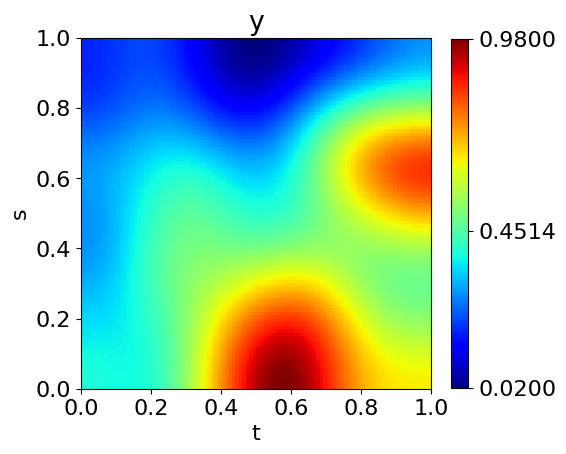

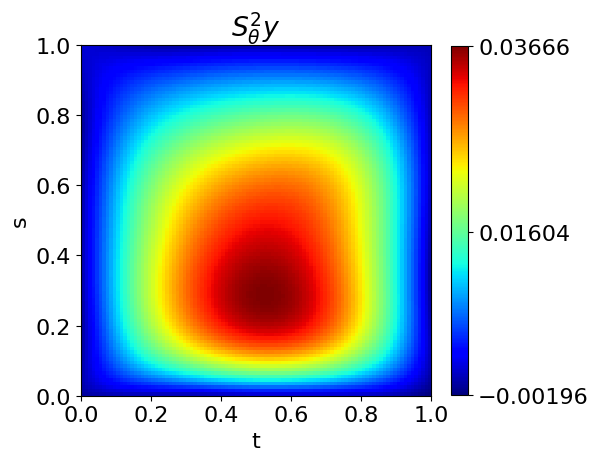

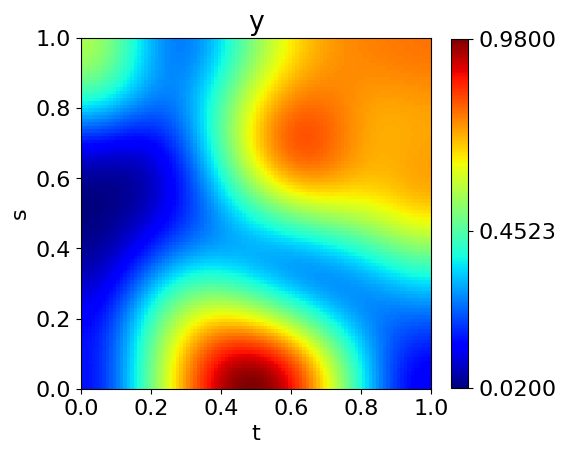

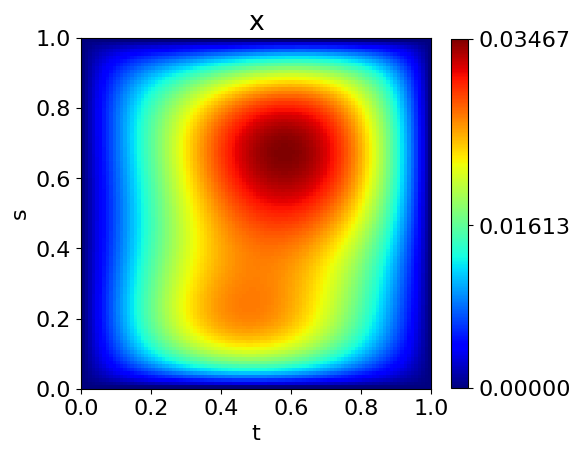

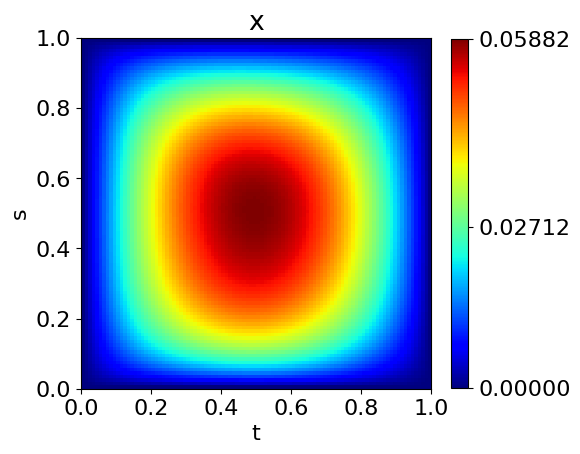

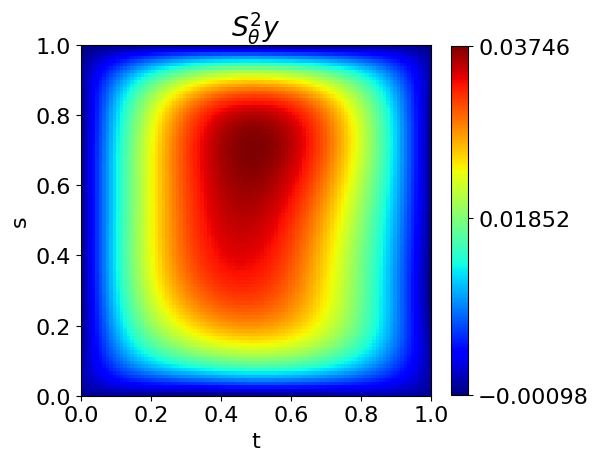

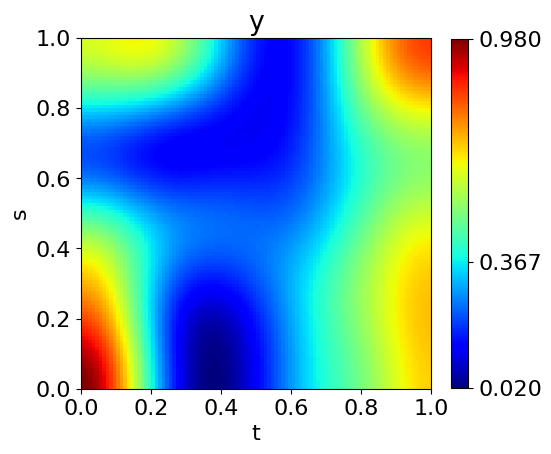

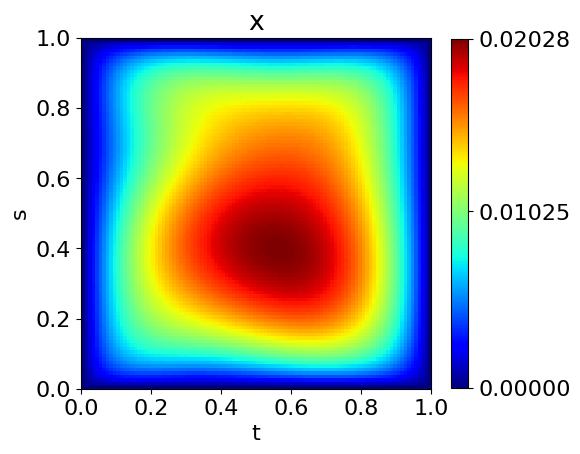

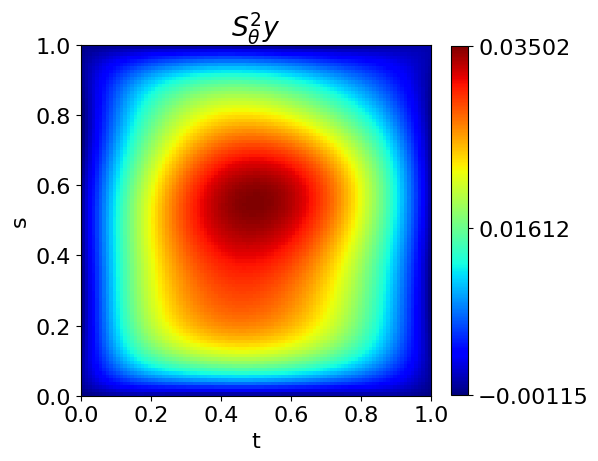

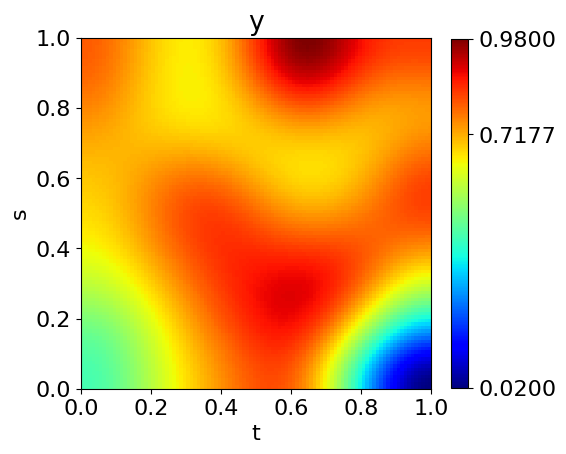

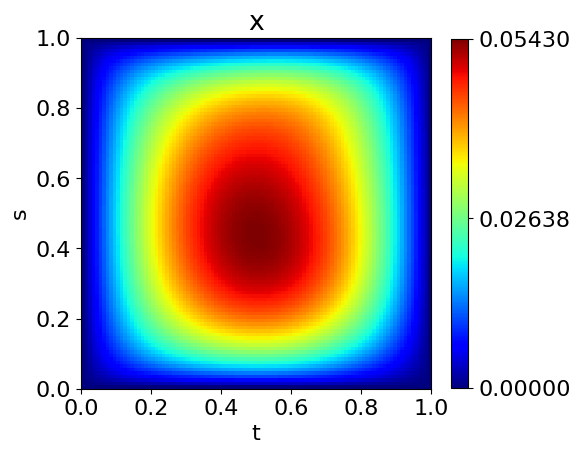

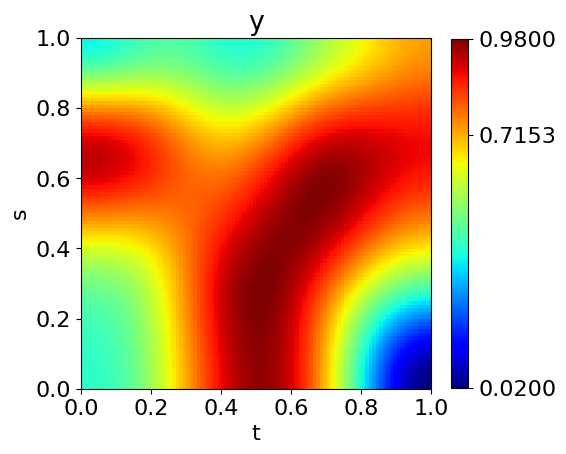

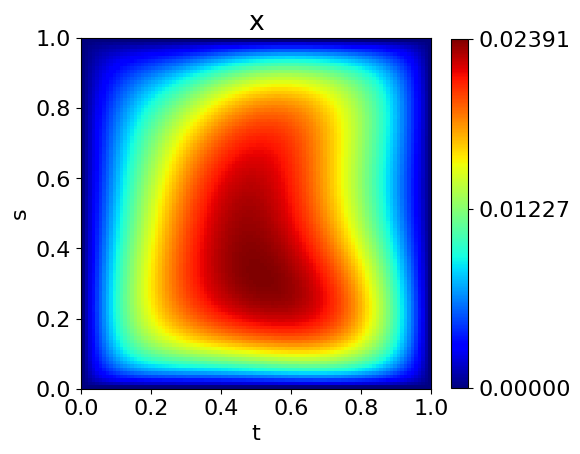

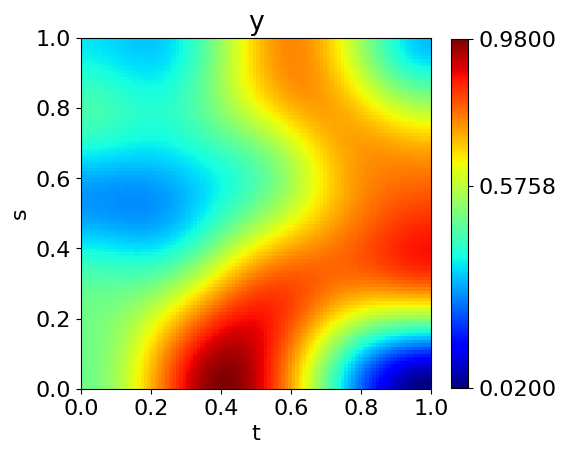

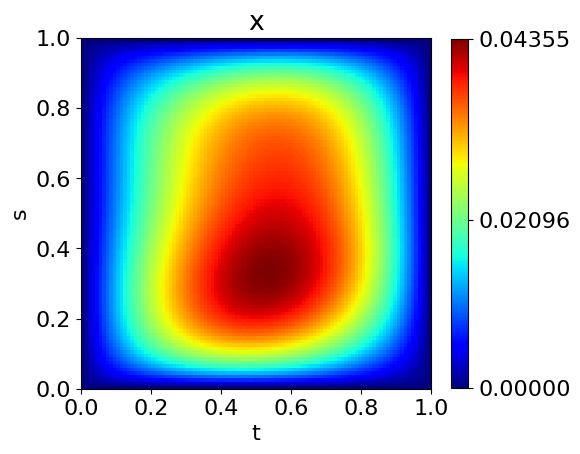

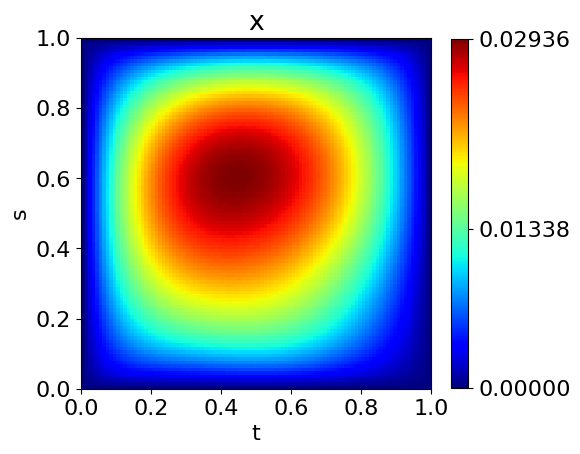

In [7]:
x_ds, y_ds = torch.load(PATH / params["name"] / 'valid.ds')
size = len(x_ds)
step = size // 10

N = 100
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1)

for i, idx in enumerate(range(0, size, step)):
    Y = torch.load(f'dataset/{params["ds"]}/valid/{i}_Y.pt')
    X = torch.load(f'dataset/{params["ds"]}/valid/{i}_X.pt')

    ip = torch.linspace(0, 1, len(X)).numpy()
    
    x_pred = model(x_ds[idx].unsqueeze(dim=0), tt)
    x_pred = x_pred.reshape(N, N)

    plt.figure(figsize=(5, 5))
    plt.imshow(Y.T, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.title('y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_#Fig{i}.png', bbox_inches='tight')
    
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(Y))
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_#Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(X.T, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.title('x')
    if savefig:
        plt.savefig(FIGURES_PRED / f'x_#Fig{i}.png', bbox_inches='tight')
    
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(X))
    if savefig:
        plt.savefig(FIGURES_PRED / f'x_#Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(x_pred, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.title(r'$S^2_{\theta} y$')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{params["name"]}_#{epoch}_#Fig{i}.png', bbox_inches = 'tight')

    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(x_pred))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{params["name"]}_#{epoch}_#Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.close('all')
    gc.collect(2)

# Kernel

In [6]:
N = 100
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1)

kernel = torch.zeros(N**2, N**2)

for k, t1t2 in enumerate(tt.T):
    t1t2_expand = t1t2.expand(N**2, -1).T
    input = torch.cat((t1t2_expand, tt)).T
    kernel[k] = K(input).squeeze()

In [7]:
kernel = kernel.view(N**2, N**2).flip(0)

In [10]:
ticks_freq = N**2 // 20
ticks_position = [i for i in range(0, N**2, ticks_freq)]
ticks_label = []
for i in ticks_position:
    col = (i % N) + (N-1)
    row = i // N
    ticks_label.append(f'({t[len(t)-1-row]:.2f},{t[col]:.2f})')

plt.figure(figsize=(10, 10))
plt.imshow(kernel, cmap='jet')
plt.xticks([])
plt.yticks(ticks_position, ticks_label)
plt.xlabel(r'$t\in (0,1)^2$', fontsize=16)
plt.ylabel(r'$s\in (0,1)^2$', fontsize=16)
plt.colorbar(location='right', fraction=0.045)
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{params["name"]}_#{epoch}_res{N}.png', bbox_inches='tight')

plt.title(r'$S^2_{\theta}$' + f' at epoch {epoch}')
plt.show()

# Kernel2Basis

In [8]:
U, S, _ = torch.linalg.svd(kernel)

In [9]:
EIGV = sorted(1/S[:8], reverse=True)
print(EIGV)

[tensor(0.0119), tensor(0.0104), tensor(0.0081), tensor(0.0071), tensor(0.0071), tensor(0.0048), tensor(0.0031), tensor(0.0020)]


In [12]:
BASIS = U.T[:8]

EIGV = []
for i, b in enumerate(BASIS):
    bint = Interp2D((t.numpy(), t.numpy()), b.reshape(N, N).numpy())(int_p.T.numpy())
    bint = torch.tensor(bint, dtype=torch.float32)
    num = (bint * model(bint, int_p)) @ int_w
    den = (bint * bint) @ int_w
    EIGV.append(num / den)

EIGV = torch.tensor(EIGV)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]

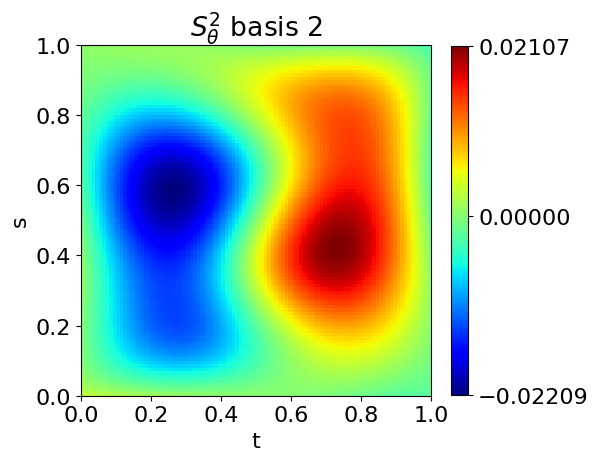

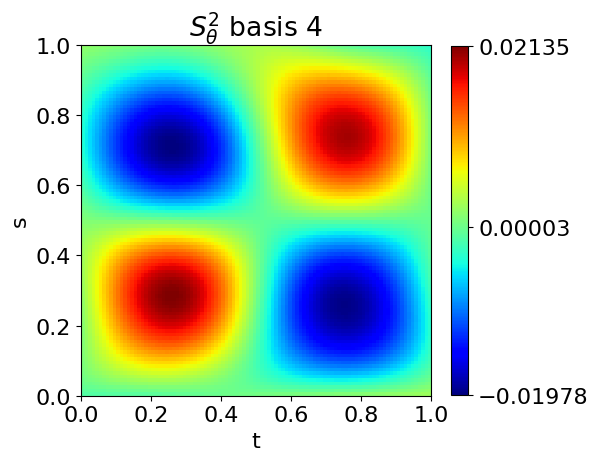

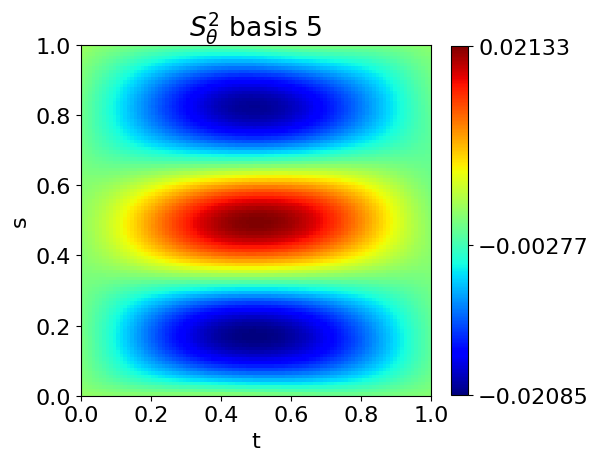

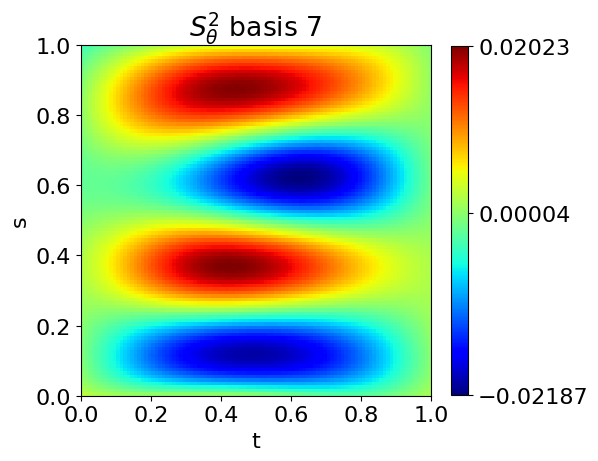

In [13]:
for i, b in enumerate(BASIS):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.reshape(N, N), cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(b))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_#{epoch}_#Fig{i}.png', bbox_inches='tight')

    plt.title(r'$S^2_{\theta}$ basis ' + str(i+1))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_#{epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

In [14]:
#  Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]
_, int_w_aux, _, _ = quad.trapezoidal_rule(N) 
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

O_BASIS = torch.stack(Q)

EIGV = []
for i, b in enumerate(O_BASIS):
    bint = Interp2D((t.numpy(), t.numpy()), b.reshape(N, N).numpy())(int_p.T.numpy())
    bint = torch.tensor(bint, dtype=torch.float32)
    num = (bint * model(bint.unsqueeze(0), int_p)) @ int_w
    den = (bint * bint) @ int_w
    EIGV.append(num / den)
    gc.collect()

EIGV = torch.tensor(EIGV)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
O_BASIS = O_BASIS[idx]

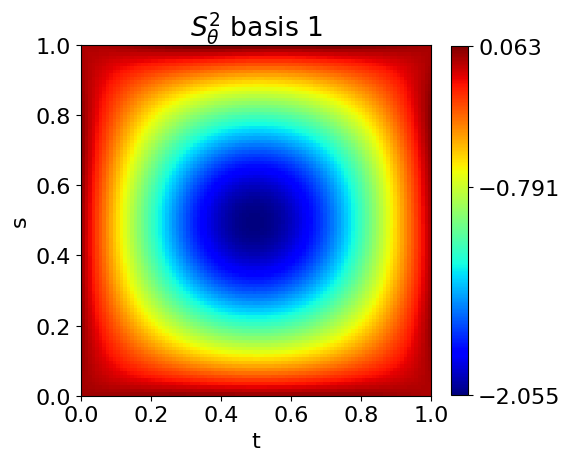

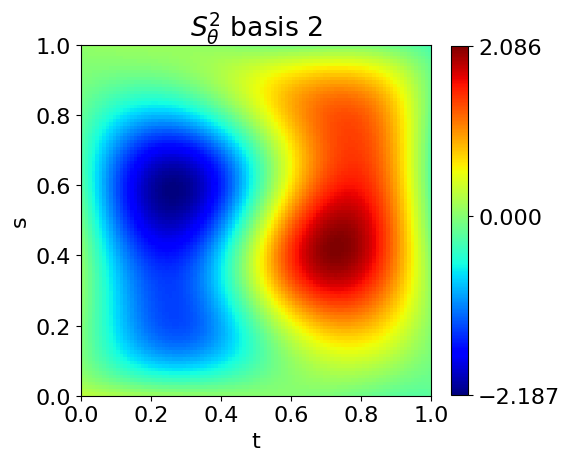

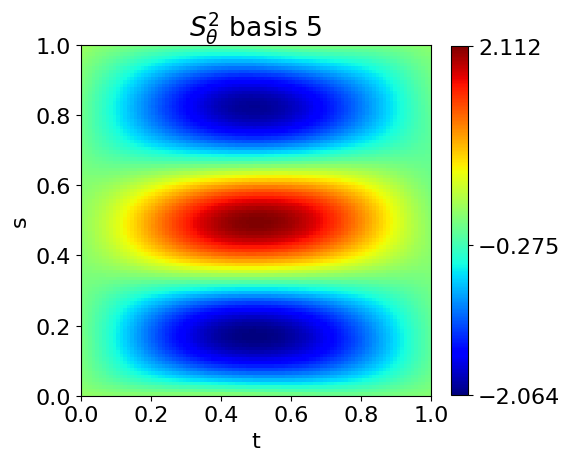

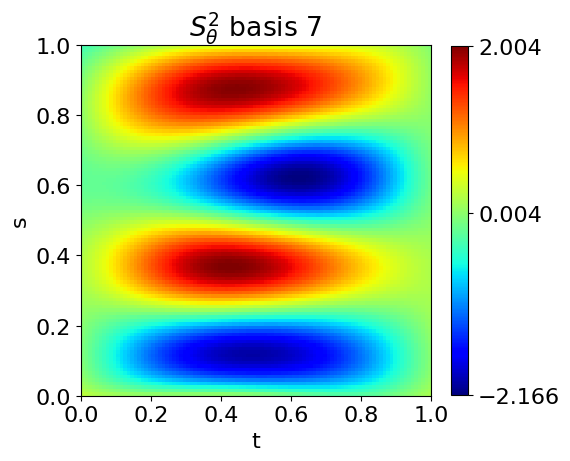

In [16]:
for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.reshape(N, N), cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(b))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_orth_#{epoch}_#Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^2_{\theta}$ basis ' + str(i+1))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{params["name"]}_orth_#{epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()


kernel_estimated = torch.zeros(N**2, N**2)
for b, lmbda in zip(O_BASIS, EIGV):
    kernel_estimated += torch.outer(b, b) * lmbda

# Eigenvalue

In [15]:
Real_basis = []
Real_eigv = []

for i in range(1, 11):
    for j in range(1, 11):
        k1 = torch.tensor(i)
        k2 = torch.tensor(j)
        fun1 = torch.sin(torch.pi * k1 * tt[0])
        fun2 = torch.sin(torch.pi * k2 * tt[1])
        fun1_int = torch.sin(torch.pi * k1 * int_p[0])
        fun2_int = torch.sin(torch.pi * k1 * int_p[1])
        num = fun1 * fun2
        den = torch.sqrt((fun1_int * fun2_int)**2 @ int_w)
        Real_basis.append(num / den)
        Real_eigv.append( 1 / ((torch.pi*k1)**2 + (torch.pi*k2)**2) )

Real_basis = torch.stack(Real_basis)
Real_eigv = torch.tensor(Real_eigv)

kernel_analytic = torch.zeros(N**2, N**2)
for b, lmbda in zip(Real_basis, Real_eigv):
    kernel_analytic += torch.outer(b, b) * lmbda

idx = torch.argsort(Real_eigv, descending=True)[:8]

Real_eigv = Real_eigv[idx]
Real_basis = Real_basis[idx]

kernel_trunc = torch.zeros(N**2, N**2)
for b, lmbda in zip(Real_basis, Real_eigv):
    kernel_trunc += torch.outer(b, b) * lmbda

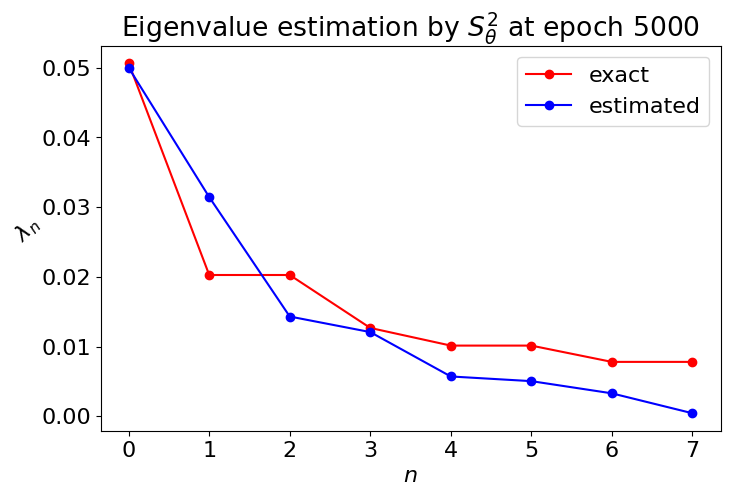

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(EIGV, 'ob-', label='estimated')
plt.xlabel(r'$n$')
plt.ylabel(r'$\lambda_n$', rotation=45)
plt.title(r'Eigenvalue estimation by $S^2_{\theta}$ at epoch ' + str(epoch))
plt.legend()
if savefig:
    plt.savefig(FIGURES_EIGV / f'{params["name"]}_#epoch{epoch}_with_title.png', bbox_inches='tight')
plt.show()

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(kernel_analytic.flip(0), cmap='jet')
plt.xticks([])
plt.yticks(ticks_position, ticks_label)
plt.xlabel(r'$t\in (0,1)^2$', fontsize=16)
plt.ylabel(r'$s\in (0,1)^2$', fontsize=16)
plt.colorbar(location='right', fraction=0.045)
plt.title('Exact kernel')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'exact.png', bbox_inches='tight')

plt.show()

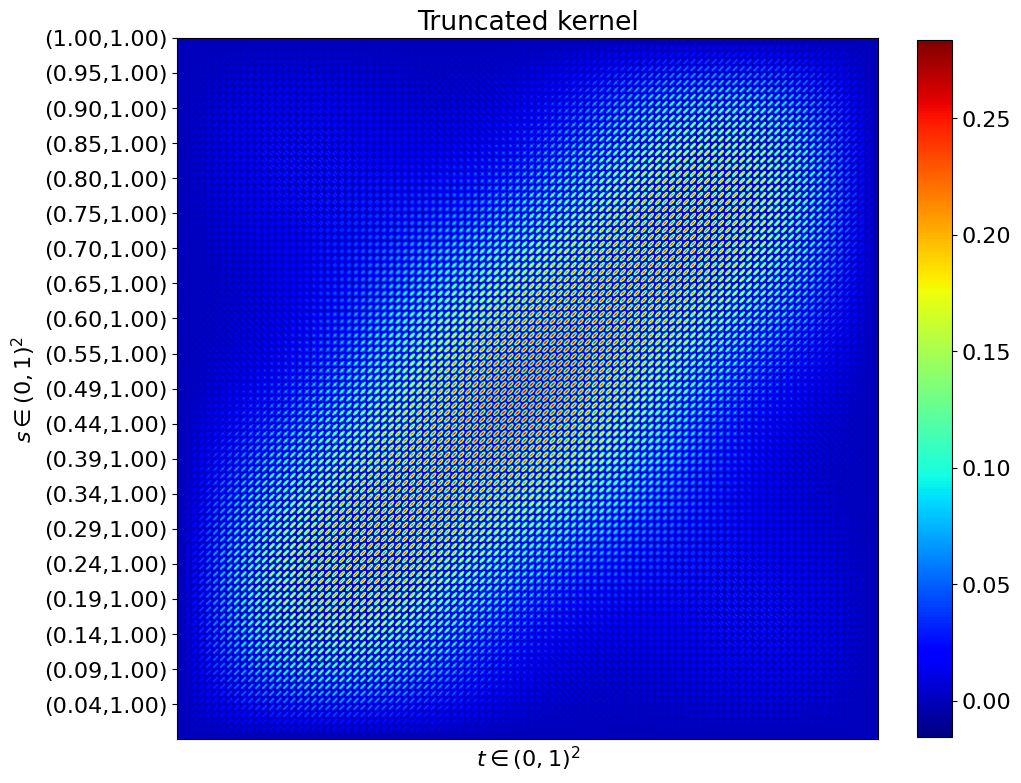

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(kernel_trunc.flip(0), cmap='jet')
plt.xticks([])
plt.yticks(ticks_position, ticks_label)
plt.xlabel(r'$t\in (0,1)^2$', fontsize=16)
plt.ylabel(r'$s\in (0,1)^2$', fontsize=16)
plt.colorbar(location='right', fraction=0.045)
plt.title('Truncated kernel')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'trunc.png', bbox_inches='tight')

plt.show()

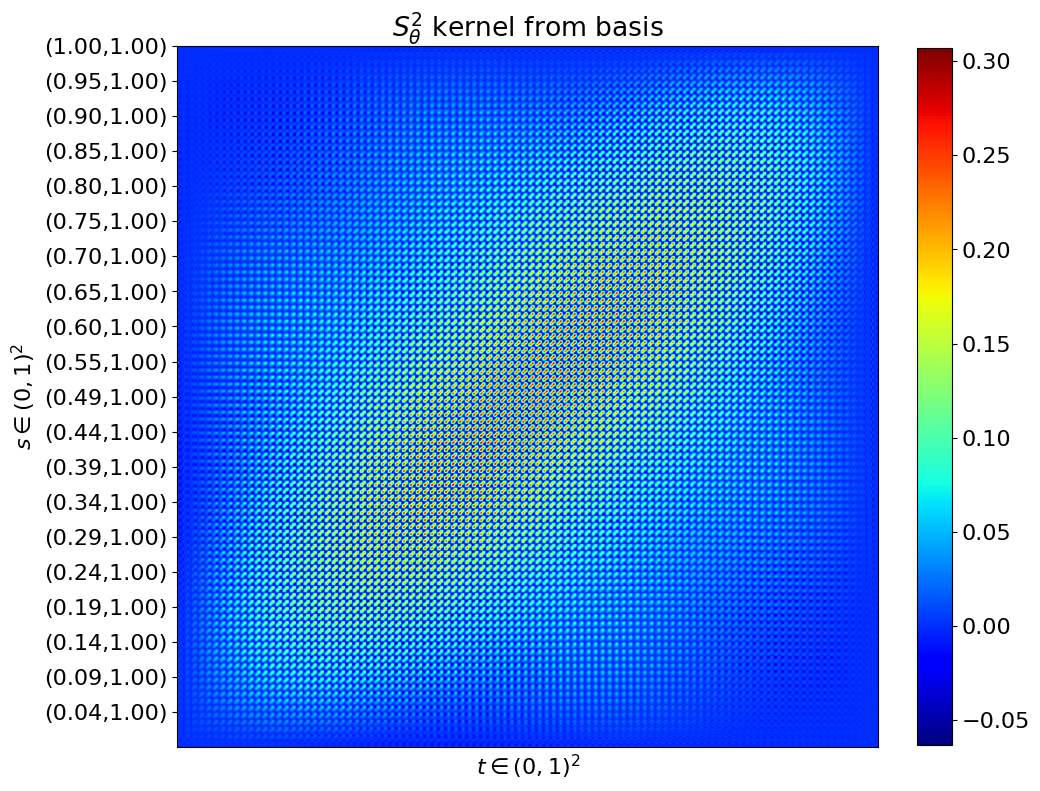

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(kernel_estimated.flip(0), cmap='jet')
plt.xticks([])
plt.yticks(ticks_position, ticks_label)
plt.xlabel(r'$t\in (0,1)^2$', fontsize=16)
plt.ylabel(r'$s\in (0,1)^2$', fontsize=16)
plt.colorbar(location='right', fraction=0.045)
plt.title(r'$S^2_{\theta}$ kernel from basis')

if savefig:
    plt.savefig(FIGURES_KERNEL / f'{params["name"]}_trunc_#{epoch}.png', bbox_inches='tight')

plt.show()

# Errors

In [22]:
def read_error_log(logfile, rf, max_epoch=-1):
    error = []
    with open(logfile) as f:
        for line in f.readlines():
            curr_epoch, err = line.split(',')

            if max_epoch > 0 and int(curr_epoch) > max_epoch:
                break
            
            if int(curr_epoch) % rf == 0:
                error.append(float(err))

    return error

In [23]:
rf = epoch // 10

valid_error = read_error_log(PATH / params['name'] / 'valid.error', rf, epoch)
train_error = read_error_log(PATH / params['name'] / 'train.error', rf, epoch)

In [24]:
print(len(valid_error))

10


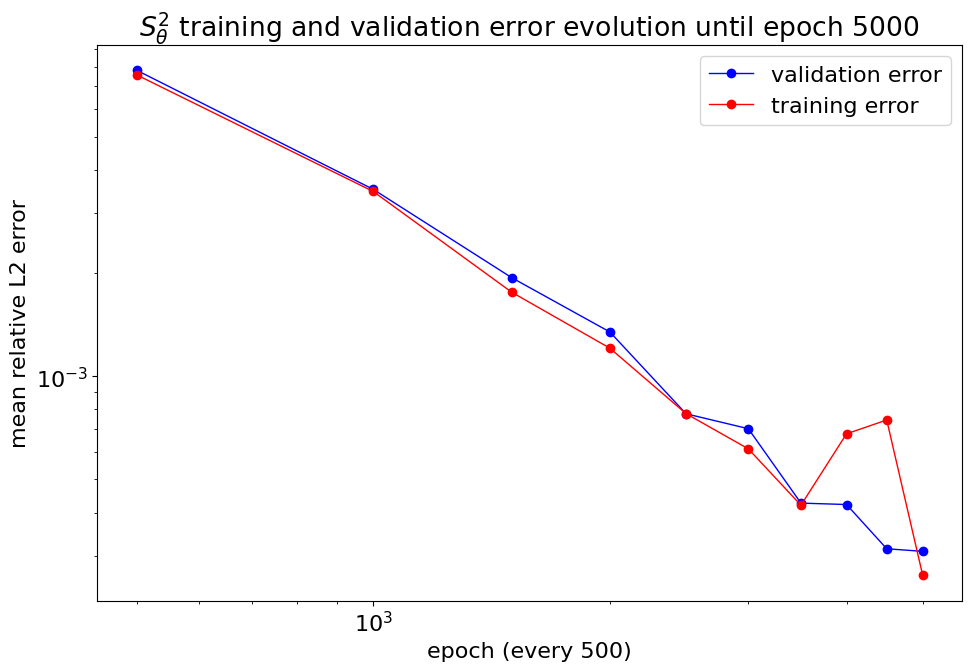

In [29]:
epoch_timeline = [k for k in range(rf, epoch+rf, rf)]

plt.figure(figsize=(10, 7))

plt.loglog(epoch_timeline, valid_error, 'ob-', label='validation error', linewidth=1)
plt.loglog(epoch_timeline, train_error, 'or-', label='training error', linewidth=1)
plt.xlabel(f'epoch (every {rf})')
plt.ylabel('mean relative L2 error')
plt.title(r'$S^2_{\theta}$' + f' training and validation error evolution until epoch {epoch}')
plt.tight_layout()
plt.legend()
if savefig:
    plt.savefig(FIGURES_ERROR / f'{params["name"]}_#epoch{epoch}_with_title.png')

<Figure size 800x500 with 0 Axes>

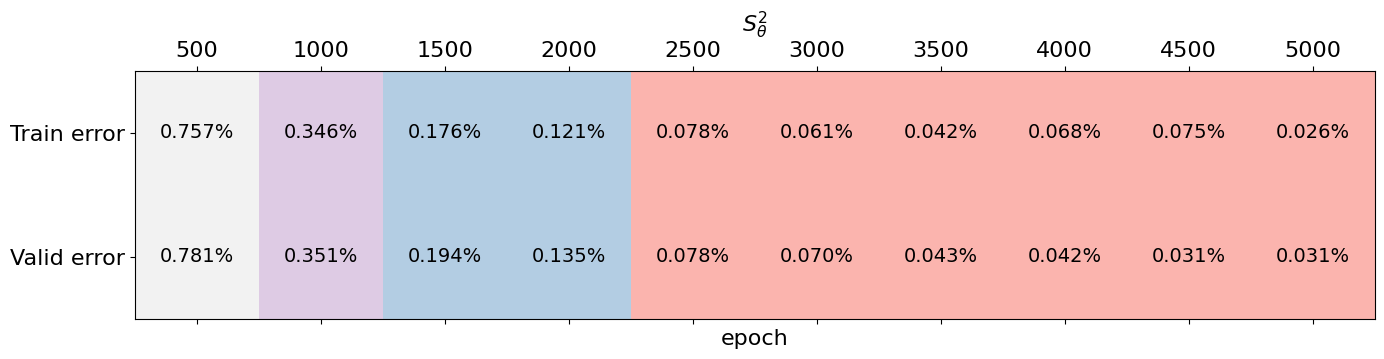

In [28]:
import numpy as np

data = np.array(list(zip(train_error, valid_error))).T

plt.figure(figsize=(8, 5))
plt.tight_layout()
plt.matshow(100 * data, cmap='Pastel1')
plt.xlabel('epoch')
plt.xticks(np.array(range(len(epoch_timeline))), epoch_timeline)
plt.yticks(list(range(2)), ['Train error', 'Valid error'])
plt.title(r'$S^2_{\theta}$', fontsize=16)

for (i, j), z in np.ndenumerate(data):
    plt.text(j, i, '{:0.3f}%'.format(100 * z), ha='center', va='center', fontsize=14)

if savefig:
    plt.savefig(FIGURES_ERROR / f'{params["name"]}_#epoch{epoch}_table.png', bbox_inches='tight')
plt.show()